<a href="https://colab.research.google.com/github/vignu10/parker-demographics/blob/main/metropolis_demographics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parking Demographics

In [ ]:
!pip install streamlit pyngrok --quiet
!ngrok config add-authtoken "2vDQfw2yQqmACKriP58DWbpt4js_7vV4C82j6MxgdhNgqhz1Q"


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]  # Save uploaded file name

Saving extensive_diverse_parking_data.csv to extensive_diverse_parking_data.csv


In [ ]:
# 🚀 3. Upload Car Price Dataset
print("Upload your full_car_price_dataset.csv file")
uploaded_price = files.upload()
price_filename = list(uploaded_price.keys())[0]

Upload your full_car_price_dataset.csv file


Saving Full_Car_Price_Dataset.csv to Full_Car_Price_Dataset.csv


In [ ]:
import pandas as pd
import numpy as np
import os
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Read both files
df = pd.read_csv(filename)
car_prices = pd.read_csv(price_filename)

# Merge price and year using make and model
df = df.merge(car_prices, on=["Make", "Model"], how="left")

Price Prediction R² Score: 0.9652911357960369
Vehicle Segment Model Accuracy: 0.9085098612125639


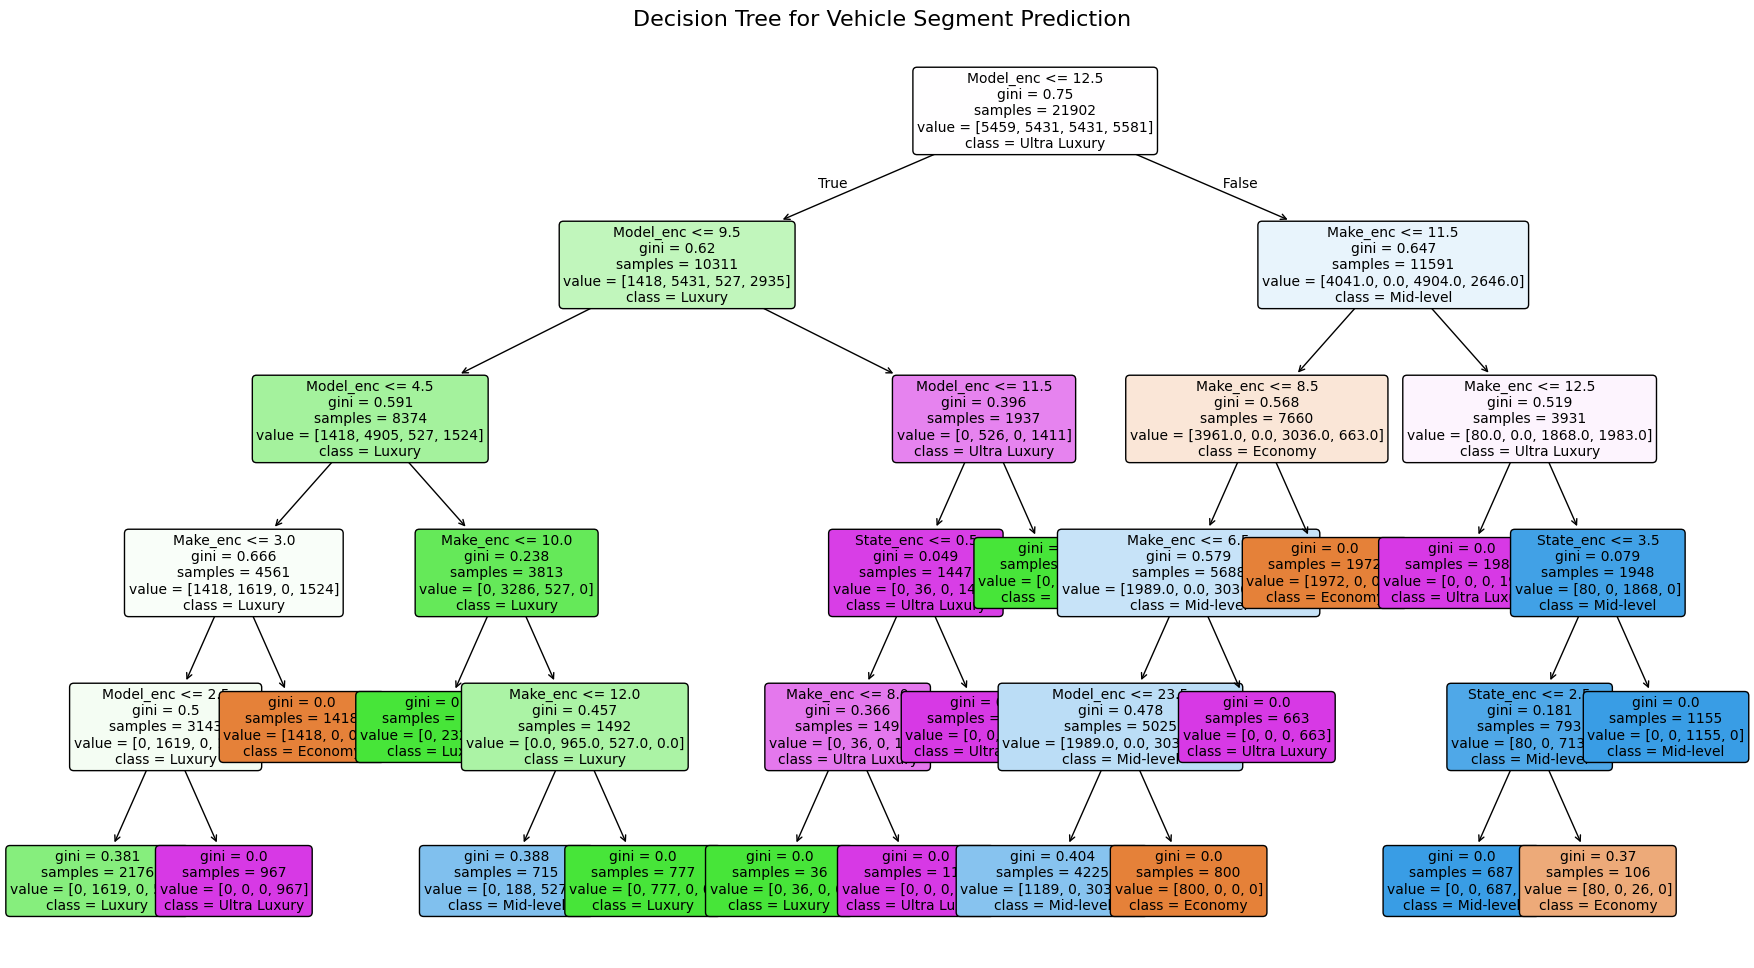

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Load your data

# --- Segment 2: Parking Pattern Classification ---
def classify_parking_pattern(row):
    entry = pd.to_datetime(row["Entry Time"])
    exit = pd.to_datetime(row["Exit Time"])
    duration = (exit - entry).total_seconds() / 3600
    validated = row["Validated Amount"]

    if duration <= 3:
        return "Short-Term Validated" if validated > 0 else "Short-Term Non-Validated"
    else:
        return "Long-Term Validated" if validated > 0 else "Long-Term Non-Validated"

df["Parking Pattern"] = df.apply(classify_parking_pattern, axis=1)

# --- Segment 3: Time of Parking ---
def classify_time_segment(row):
    hour = pd.to_datetime(row["Entry Time"]).hour
    if 6 <= hour <= 9:
        return "Morning Rush"
    elif 10 <= hour <= 15:
        return "Midday"
    elif 17 <= hour <= 21:
        return "Evening"
    else:
        return "Late Night"

df["Time Segment"] = df.apply(classify_time_segment, axis=1)

# --- Encode Categorical Variables ---
df["Make_enc"] = LabelEncoder().fit_transform(df["Make"].astype(str))
df["Model_enc"] = LabelEncoder().fit_transform(df["Model"].astype(str))
df["State_enc"] = LabelEncoder().fit_transform(df["State"].astype(str))

# ---------------------------
# (A) Predict Price (Regression)
# ---------------------------
X_price = df[["Make_enc", "Model_enc", "State_enc"]]
y_price = df["Price"]
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(X_price, y_price, test_size=0.2, random_state=42)

reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train_price, y_train_price)
df["Estimated Price"] = reg.predict(X_price)

print("Price Prediction R² Score:", reg.score(X_test_price, y_test_price))

# ---------------------------
# Dynamically Label Vehicle Segment (4 Tiers)
# ---------------------------
# Get price percentiles
p25 = df["Estimated Price"].quantile(0.25)
p50 = df["Estimated Price"].quantile(0.50)
p75 = df["Estimated Price"].quantile(0.75)

def dynamic_label_vehicle_segment(p):
    if p >= p75:
        return "Ultra Luxury"
    elif p >= p50:
        return "Luxury"
    elif p >= p25:
        return "Mid-level"
    return "Economy"

df["Vehicle Segment"] = df["Estimated Price"].apply(dynamic_label_vehicle_segment)

# ---------------------------
# (B) Predict Vehicle Segment (Classification)
# ---------------------------
X_seg = df[["Make_enc", "Model_enc", "State_enc"]]
y_seg = df["Vehicle Segment"]
X_train_seg, X_test_seg, y_train_seg, y_test_seg = train_test_split(X_seg, y_seg, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train_seg, y_train_seg)
df["Predicted Segment"] = clf.predict(X_seg)

print("Vehicle Segment Model Accuracy:", clf.score(X_test_seg, y_test_seg))

# ---------------------------
# Save enriched data
# ---------------------------
df.to_csv("enriched_data.csv", index=False)

# ---------------------------
# Plot the Decision Tree
# ---------------------------
class_labels = [str(cls) for cls in clf.classes_]

plt.figure(figsize=(22, 12))
plot_tree(
    clf,
    feature_names=["Make_enc", "Model_enc", "State_enc"],
    class_names=class_labels,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree for Vehicle Segment Prediction", fontsize=16)
plt.show()

In [ ]:
with open("app.py", "w") as f:
    f.write('''
import streamlit as st
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from io import StringIO

st.set_page_config(page_title="Parked Car Demographics", layout="wide")
st.title("🚗 Parked Car Demographics Dashboard")

# Load enriched data
df = pd.read_csv("enriched_data.csv")

# Sidebar: Filter by Location
st.sidebar.header("🔍 Filter Options")
all_locations = sorted(df["Location"].dropna().unique())
selected_locations = st.sidebar.multiselect("📍 Select One or More Locations", all_locations, default=all_locations[:1])

# Filter Data
filtered_df = df[df["Location"].isin(selected_locations)]

# Use ColorBrewer's qualitative Set2 palette for distinguishable color coding
color_palette = px.colors.qualitative.Set2
color_map = {loc: color_palette[i % len(color_palette)] for i, loc in enumerate(all_locations)}

if not selected_locations:
    st.warning("Please select at least one location to view the data.")
else:
    # 📋 Summary + Export
    st.subheader("📋 Filtered Data & Export")
    st.dataframe(filtered_df)

    csv_data = filtered_df.to_csv(index=False)
    st.download_button("⬇️ Download Filtered Data as CSV", csv_data, "filtered_data.csv", "text/csv")

    # 📊 Vehicle Segment Distribution by Location
    st.subheader("📊 Segmented Vehicle Distribution per Location")
    grouped = filtered_df.groupby(["Predicted Segment", "Location"]).size().reset_index(name="Count")
    segment_order = ["Economy", "Mid-level", "Luxury"]
    grouped["Predicted Segment"] = pd.Categorical(grouped["Predicted Segment"], categories=segment_order, ordered=True)

    fig1 = px.bar(
        grouped,
        x="Predicted Segment",
        y="Count",
        color="Location",
        barmode="group",
        category_orders={"Predicted Segment": segment_order},
        color_discrete_map=color_map,
        hover_data=["Count", "Location"]
    )
    fig1.update_layout(
        title="Segmented Vehicle Distribution per Location",
        xaxis_title="Vehicle Segment",
        yaxis_title="Number of Vehicles",
        legend_title="Location",
        bargroupgap=0.2  # Add spacing between location groups
    )
    st.plotly_chart(fig1, use_container_width=True)

    # 💰 Vehicle Price Distribution
    st.subheader("💰 Vehicle Price Distribution")
    fig2 = go.Figure()
    for loc in selected_locations:
        loc_data = filtered_df[filtered_df["Location"] == loc]["Price"]
        fig2.add_trace(go.Histogram(
            x=loc_data,
            name=loc,
            opacity=0.65,
            nbinsx=20,
            marker_color=color_map.get(loc)
        ))
    fig2.update_layout(
        barmode='overlay',
        xaxis_title='Price ($)',
        yaxis_title='Vehicle Count',
        title='Price Distribution per Location',
        legend_title='Location'
    )
    st.plotly_chart(fig2, use_container_width=True)

    # ⏱️ Hourly Traffic Volume
    st.subheader("⏱️ Traffic Volume by Hour")
    filtered_df["Entry Hour"] = pd.to_datetime(filtered_df["Entry Time"]).dt.hour
    hourly = filtered_df.groupby(["Entry Hour", "Location"]).size().reset_index(name="Count")

    fig3 = go.Figure()
    for loc in selected_locations:
        data = hourly[hourly["Location"] == loc]
        fig3.add_trace(go.Scatter(
            x=data["Entry Hour"],
            y=data["Count"],
            mode='lines+markers',
            name=loc,
            line=dict(color=color_map.get(loc))
        ))
    fig3.update_layout(
        title="Hourly Entry Traffic Volume",
        xaxis_title="Hour of Day",
        yaxis_title="Vehicles",
        hovermode="x unified",
        legend_title="Location"
    )
    st.plotly_chart(fig3, use_container_width=True)

    # 💸 Revenue Comparison
    st.subheader("💸 Total & Validated Revenue by Location")
    rev = filtered_df.groupby("Location")[["Total Amount", "Validated Amount"]].sum().reset_index()

    fig4 = go.Figure()
    for loc in selected_locations:
        total = rev[rev["Location"] == loc]["Total Amount"].values[0]
        validated = rev[rev["Location"] == loc]["Validated Amount"].values[0]
        fig4.add_trace(go.Bar(
            name=f"{loc} - Total",
            x=[loc],
            y=[total],
            marker_color=color_map.get(loc)
        ))
        fig4.add_trace(go.Bar(
            name=f"{loc} - Validated",
            x=[loc],
            y=[validated],
            marker_color=color_map.get(loc),
            opacity=0.5
        ))
    fig4.update_layout(
        barmode='group',
        xaxis_title="Location",
        yaxis_title="Revenue ($)",
        title="Total vs Validated Revenue",
        legend_title="Legend",
        bargap=0.3
    )
    st.plotly_chart(fig4, use_container_width=True)
''')

In [ ]:
from pyngrok import ngrok
import time
import os

ngrok.kill()
os.system('streamlit run app.py &')
time.sleep(3)

public_url = ngrok.connect(addr="8501", proto="http")
print(f"✅ Your Streamlit app is live at: {public_url}")

✅ Your Streamlit app is live at: NgrokTunnel: "https://d025-34-75-152-179.ngrok-free.app" -> "http://localhost:8501"


# LPR Data Extractor

In [ ]:
import pandas as pd
import numpy as np
lpr_df = pd.read_csv("/content/car_parking_data (1).csv")
lpr_df["Price"] = np.random.choice([18000, 25000, 32000, 42000, 55000], size=len(lpr_df))# Simulate that locations 55141, 42338, and 99755 belong to zone 'Zone-A'
zone_a_ids = ['55141', '42338', '99755']
lpr_df["Location"] = lpr_df["Location"].astype(str)  # Ensure consistent string type
lpr_df.loc[lpr_df["Location"].isin(zone_a_ids), "Location"] = "Zone-A"
lpr_df["Validated Amount"] = lpr_df["Total Amount"] * np.random.uniform(0, 1, len(lpr_df))
lpr_df["Entry Time"] = pd.to_datetime(lpr_df["Entry Time"])
lpr_df["Exit Time"] = lpr_df["Entry Time"] + pd.to_timedelta(np.random.uniform(1, 8, len(lpr_df)), unit="h")
new_path = "tested.csv"
lpr_df = lpr_df.drop(columns=['Year', 'Price'])
lpr_df
lpr_df.to_csv(new_path, index=False)

# New Section

In [ ]:
!pip install python-pptx
!pip install Pillow
from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.enum.text import PP_ALIGN

# Create a new presentation
prs = Presentation()

# ----------------------------
# Slide 1: Title Slide
slide = prs.slides.add_slide(prs.slide_layouts[0])
slide.shapes.title.text = "Parker Demographics"
subtitle = slide.placeholders[1]
subtitle.text = ("Analyze parked car data to reveal visitor demographics, helping property owners attract high‐rental clients.\n\n"
                 "Suresh P Role   Rahulraj R Role   Vigneshwar C U Role")

# ----------------------------
# Slide 2: Problem Statement
slide = prs.slides.add_slide(prs.slide_layouts[1])
slide.shapes.title.text = "Problem Statement"
content = slide.placeholders[1]
content.text = ("• We analyze parked car data (license plate state, car make, and model) to infer visitor demographics.\n"
                "• Business Impact: Helps property owners target high-rental clients by tailoring marketing and pricing strategies.\n"
                "• Primary Users: Garage owners and parking lot operators.\n"
                "• Benefit: Thousands of garages serving hundreds of vehicles daily can leverage these insights.")

# ----------------------------
# Slide 3: Proposed Solution
slide = prs.slides.add_slide(prs.slide_layouts[1])
slide.shapes.title.text = "Proposed Solution"
content = slide.placeholders[1]
content.text = ("• Our solution processes parked car data to build a demographic profile for each location.\n"
                "• It combines vehicle attributes with external socioeconomic data to create a robust segmentation model.\n"
                "• Unlike other methods, our approach leverages real-time parking data to increase revenue opportunities by attracting premium tenants and reducing marketing costs.")

# ----------------------------
# Slide 4: Technical Implementation
slide = prs.slides.add_slide(prs.slide_layouts[5])
# Add title using a textbox for more design control
title_box = slide.shapes.add_textbox(Inches(0.5), Inches(0.2), Inches(9), Inches(1))
tf_title = title_box.text_frame
p = tf_title.add_paragraph()
p.text = "Technical Implementation"
p.font.size = Pt(32)
p.alignment = PP_ALIGN.CENTER

# Add technical details as bullet points
tech_box = slide.shapes.add_textbox(Inches(0.5), Inches(1.2), Inches(5), Inches(3))
tf_tech = tech_box.text_frame
tf_tech.text = ("• Data ingestion from parked car sensors and license plate recognition.\n"
                "• Data enrichment with car valuation and state socioeconomic indicators.\n"
                "• Feature engineering to derive vehicle and location metrics.\n"
                "• Clustering algorithms (e.g., KMeans) for demographic segmentation.\n"
                "• Scalable architecture using Python, pandas, and scikit-learn.")

# Insert an interactive image (e.g., an architecture diagram)
left = Inches(6.2)
top = Inches(1.2)
height = Inches(3)
try:
    pic = slide.shapes.add_picture("architecture_diagram.jpg", left, top, height=height)
    # Set the image to be clickable and link to an external resource (e.g., detailed architecture document)
    pic.click_action.hyperlink.address = "https://example.com/architecture"
except Exception as e:
    print("Error adding interactive image:", e)

# ----------------------------
# Slide 5: Demo
slide = prs.slides.add_slide(prs.slide_layouts[1])
slide.shapes.title.text = "Demo"
content = slide.placeholders[1]
content.text = ("• Live demonstration of the data pipeline and clustering algorithm.\n"
                "• Walkthrough of the interactive dashboard showing real-time insights.\n"
                "• Highlight key features such as data visualization and aggregated metrics by parking location.")

# ----------------------------
# Slide 6: Next Steps
slide = prs.slides.add_slide(prs.slide_layouts[1])
slide.shapes.title.text = "Next Steps"
content = slide.placeholders[1]
content.text = ("• Further enhance data enrichment with additional demographic sources.\n"
                "• Refine clustering models and explore supervised learning options for prediction.\n"
                "• Develop a production-grade interactive dashboard for real-time insights.\n"
                "• Scale the solution to additional regions and integrate with property management systems.")

# ----------------------------
# Slide 7: Links
slide = prs.slides.add_slide(prs.slide_layouts[1])
slide.shapes.title.text = "Links"
content = slide.placeholders[1]
content.text = ("• Codebase: https://github.com/yourusername/parkerdemographics\n"
                "• Demo Video: https://youtu.be/your-demo-video\n"
                "• Additional Resources: https://example.com/resources")

# Save the presentation
ppt_filename = "Parker_Demographics_Final.pptx"
prs.save(ppt_filename)
print(f"PPT file '{ppt_filename}' created successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 10.5 MB/s eta 0:00:00
Error adding interactive image: [Errno 2] No such file or directory: 'architecture_diagram.jpg'
PPT file 'Parker_Demographics_Final.pptx' created successfully!
